In [487]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from fwi_predict.constants import TZ_STRING

In [488]:
raw = pd.read_excel("../data/raw/June 2021-December 2024 Data From Tool_No Filter_No Tests.xlsx")

### Clean column names

In [489]:
raw = raw.rename(columns=lambda s: s.lower() \
                                  .replace(' ', '_') \
                                  .replace('(', '') \
                                  .replace(')', '') \
                                  .replace('°', '') \
                                  .replace('?', '') \
                                  .replace('/', '_per_') \
                                  .replace('_per_l', '_per_L')) 


In [490]:
raw = raw.rename(columns={
  'sr._no': 'serial_num',
  'date_of_data_collection': 'date',
  'time_of_data_collection': 'sample_time',
  'type': 'time_of_day',
  'turbidity_in_cm': 'turbidity_cm'
})

In [491]:
raw.columns

Index(['serial_num', 'date', 'sample_time', 'pond_id', 'farmer', 'time_of_day',
       'is_follow_up', 'is_follow_up_possible',
       'reason_follow_up_not_possible', 'group', 'pond_status', 'observer',
       'equipment', 'weather', 'do_mg_per_L', 'ph', 'turbidity_cm',
       'ammonia_mg_per_L', 'temp_in_c', 'tds_ppt', 'alkalinity_mg_per_L',
       'hardness_mg_per_L', 'water_color', 'is_wq_in_range',
       'parameters_out_of_range', 'corrective_actions_requested',
       'corrective_actions_requested_other',
       'corrective_actions_amount_requested', 'corrective_actions_implemented',
       'corrective_actions_implementation_date', 'corrective_actions_taken',
       'corrective_actions_taken_other', 'corrective_actions_taken_details',
       'non-prescribed_corrective_actions_taken', 'reason_not_implemented',
       'water_quality_improved_after_corrective_actions',
       'corrective_action_notes', 'individuals_air_gulping',
       'individuals_tail_splashing', 'dead_fish', 'no

There are more columns we can explore later if we were to take time series approach but sticking with simple quantitative for now.

In [492]:
keep_cols = ['serial_num', 'date', 'sample_time', 'pond_id', 'time_of_day', 'is_follow_up',
             'group', 'pond_status', 'equipment', 'do_mg_per_L', 'ph', 'turbidity_cm', 'tds_ppt', 'ammonia_mg_per_L']

explore_ds = raw[keep_cols].copy()

In [493]:
len(explore_ds['serial_num'].unique()) == len(explore_ds) # Check serial numbers are unique

True

In [494]:
explore_ds['follow_up'] = explore_ds['is_follow_up'].map(lambda s: False if s == 'No' else True)
explore_ds = explore_ds.drop(columns='is_follow_up')
explore_ds['follow_up'].value_counts(dropna=False)

follow_up
False    6668
True      941
Name: count, dtype: int64

In [495]:
explore_ds['pond_status'].value_counts(dropna=False)

pond_status
Treatment     6847
Control        382
Assessment     338
NaN             42
Name: count, dtype: int64

In [496]:
explore_ds['date'] = pd.to_datetime(explore_ds['date'])

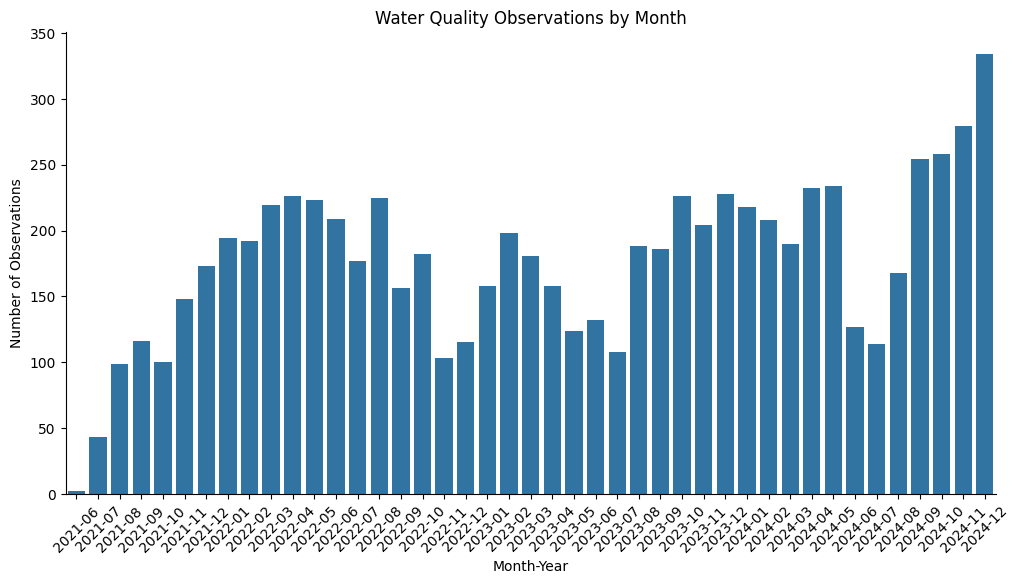

In [497]:
# Convert date to month-year and plot histogram
explore_ds['month_year'] = explore_ds['date'].dt.to_period('M')

plt.figure(figsize=(12, 6))
sns.barplot(x=explore_ds['month_year'].value_counts().sort_index().index,
            y=explore_ds['month_year'].value_counts().sort_index().values)

plt.xticks(rotation=45)
plt.title('Water Quality Observations by Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Observations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [498]:
# Combine date and sample_time into a single datetime
explore_ds['sample_dt'] = pd.to_datetime(explore_ds['date'].dt.strftime('%Y-%m-%d') + ' ' + explore_ds['sample_time'])
explore_ds['sample_dt'] = explore_ds['sample_dt'].dt.tz_localize(TZ_STRING)
explore_ds['hour'] = explore_ds['sample_dt'].dt.hour

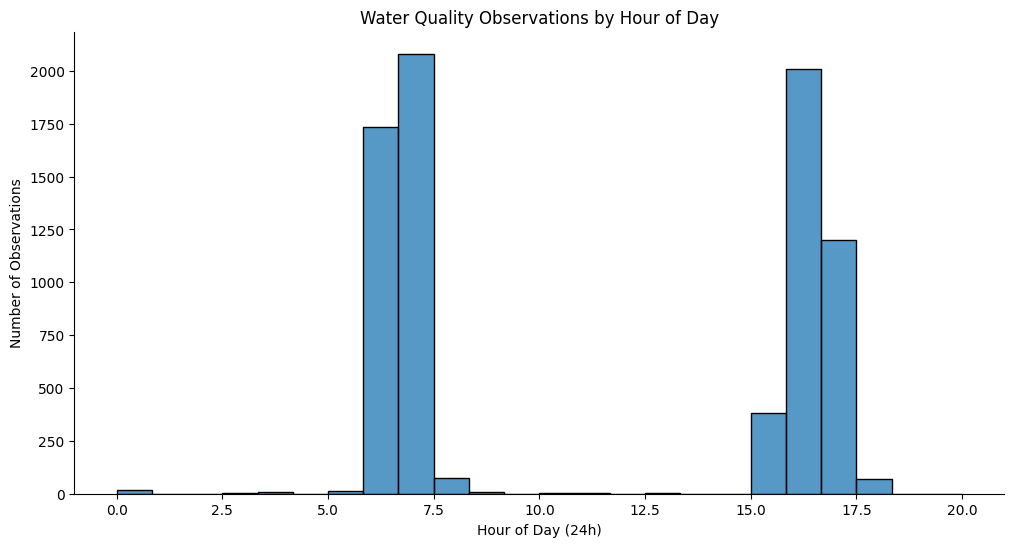

In [499]:
# Convert sample_time to hour and plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(explore_ds, x='hour', bins=24)
plt.title('Water Quality Observations by Hour of Day')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Number of Observations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Some values at midnight and some very low values. Investigate more.

In [500]:
midnight_time = explore_ds['sample_time'] == '00:00'
explore_ds[midnight_time]
len(explore_ds[midnight_time])

17

In [501]:
# Code time of day for all variables
explore_ds['time_of_day'].value_counts(dropna=False)
tod_nan = explore_ds['time_of_day'].isna()
explore_ds.loc[tod_nan, 'time_of_day'] = explore_ds.loc[tod_nan, 'hour'].map(lambda h: 'Morning' if h < 12 else 'Evening')

In [502]:
explore_ds['time_mismatch'] = ((explore_ds['hour'] < 12) & (explore_ds['time_of_day'] == 'Evening')) | ((explore_ds['hour'] >= 12) & (explore_ds['time_of_day'] == 'Morning'))
explore_ds[explore_ds['time_mismatch']]

,serial_num,date,sample_time,pond_id,time_of_day,group,pond_status,equipment,do_mg_per_L,ph,turbidity_cm,tds_ppt,ammonia_mg_per_L,follow_up,month_year,sample_dt,hour,time_mismatch
3293,5023,2023-09-27,04:17,WG-SRV1,Evening,Ara v12 monthly,Treatment,Taiwan #1,11.0,8.40,NaN,NaN,NaN,False,2023-09,2023-09-27 04:17:00+05:30,4,True
3294,5022,2023-09-27,04:08,WG-GOW1,Evening,Ara v12 monthly,Treatment,Taiwan #1,10.6,8.40,NaN,NaN,NaN,False,2023-09,2023-09-27 04:08:00+05:30,4,True
3295,5021,2023-09-27,04:01,WG-GOW2,Evening,Ara v12 monthly,Treatment,Taiwan #1,11.2,8.40,NaN,NaN,NaN,False,2023-09,2023-09-27 04:01:00+05:30,4,True
5004,2610,2022-10-17,07:17,WG-VRM1,Evening,Ara v1 2 weekly,Treatment,Taiwan,12.0,8.28,38.0,781.000,0.10,False,2022-10,2022-10-17 07:17:00+05:30,7,True
5019,2595,2022-10-13,17:42,WG-NRO1,Morning,Ara v1 2 weekly,Treatment,Taiwan,1.5,8.14,24.0,1.350,0.06,False,2022-10,2022-10-13 17:42:00+05:30,17,True
5351,2263,2022-08-17,14:05,WG-BSE1,Morning,Ara v1 2 weekly,Treatment,YSI Pro Quattro,0.8,8.50,22.0,3.792,0.31,False,2022-08,2022-08-17 14:05:00+05:30,14,True
5504,2110,2022-07-29,10:08,WG-KSS1,Evening,Ara v1 2 weekly,Assessment,YSI Pro Quattro,2.0,8.30,30.0,3.505,0.29,False,2022-07,2022-07-29 10:08:00+05:30,10,True
5774,1840,2022-06-14,11:57,WG-GRA1,Evening,Ara v1 2 weekly,Treatment,YSI Pro Quattro,11.5,8.64,28.0,1.515,0.99,False,2022-06,2022-06-14 11:57:00+05:30,11,True
5839,1774,2022-06-04,17:15,NL-NAR1,Morning,Ara v1 2 weekly,Assessment,Taiwan,1.5,7.37,34.0,0.730,0.00,False,2022-06,2022-06-04 17:15:00+05:30,17,True
5941,1673,2022-05-23,04:30,NL-FAY1,Evening,Ara v1 2 weekly,Treatment,Taiwan,9.0,8.45,34.0,NaN,0.00,False,2022-05,2022-05-23 04:30:00+05:30,4,True


I don't think the time of day or sample time variables are necessarily correct and set around the twelve hour mark. I would send to Jennifer and ask for instructions on how to clean this.

In [503]:
# Output observations we should check for errors
fp = "../data/clean/jun_21_dec_24_error_check.xlsx"
explore_ds[explore_ds['time_mismatch']].to_excel(fp, sheet_name='Time mismatch')
explore_ds[explore_ds['sample_time'] == "00:00"].to_excel(fp, sheet_name='Midnight samples')

Current rules for fixing based on what I see in data:
- If time of day is evening and hour is less than 9, assume is using twelve hour standard and update to use twenty four hour standard
- if time of day is evening and hour is greater than 9, assume is correct.
- If time of day is morning and hour is greater than twelve, assume is wrong and drop

In [504]:
# Fix sample times for mismatched morning/evening observations based on rules
evening_12hr = (explore_ds['hour'] < 9) & (explore_ds['time_of_day'] == 'Evening')
wrong_morning = (explore_ds['hour'] >= 12) & (explore_ds['time_of_day'] == 'Morning')

# Update columns
explore_ds.loc[evening_12hr, 'sample_dt'] = explore_ds.loc[evening_12hr, 'sample_dt'] + pd.Timedelta(hours=12)
explore_ds.loc[evening_12hr, 'sample_time'] = explore_ds.loc[evening_12hr, 'sample_dt'].dt.strftime('%H:%M')
explore_ds = explore_ds[~wrong_morning]

explore_ds['hour'] = explore_ds['sample_dt'].dt.hour
explore_ds['morning'] = explore_ds.hour < 12
explore_ds = explore_ds.drop(columns='time_of_day')

In [505]:
# Drop observations set at midnight
explore_ds = explore_ds[~(explore_ds['sample_time'] == '00:00')]

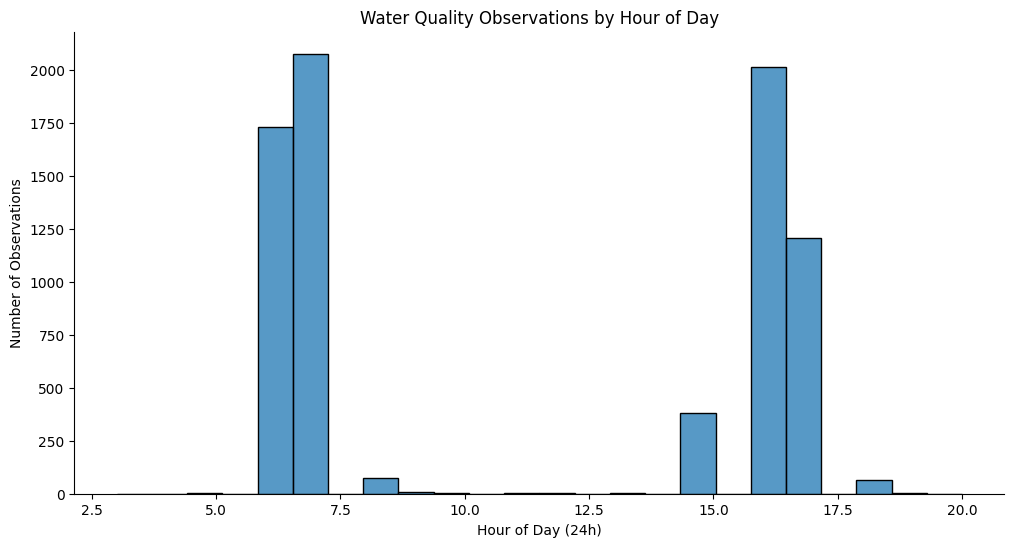

In [506]:
# Convert sample_time to hour and plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(explore_ds, x='hour', bins=24)
plt.title('Water Quality Observations by Hour of Day')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Number of Observations')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [507]:
explore_ds[explore_ds['hour'] < 5]

,serial_num,date,sample_time,pond_id,group,pond_status,equipment,do_mg_per_L,ph,turbidity_cm,tds_ppt,ammonia_mg_per_L,follow_up,month_year,sample_dt,hour,time_mismatch,morning
4244,3511,2023-03-20,03:37,NL-PSR1,Ara v12 monthly,Treatment,Taiwan #7,3.6,8.0,29.0,0.88,0.12,False,2023-03,2023-03-20 03:37:00+05:30,3,False,True


Still have some weird times after some cleaning. Raise with Jennifer.

In [508]:
equipment = explore_ds['equipment'].value_counts(dropna=False)
explore_ds['winkler'] = explore_ds['equipment'].str.contains('winkler', case=False)

Add more instrument booleans as we learn more about which ones are reliable.

In [509]:
explore_ds['do_mg_per_L']

0        9.7
1        9.8
2       11.3
3       10.3
4       10.8
        ... 
7597     7.1
7602     6.8
7605     7.9
7606     4.8
7607     9.6
Name: do_mg_per_L, Length: 7586, dtype: float64

C:\Users\squaade\AppData\Local\Temp\ipykernel_40576\1374226445.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


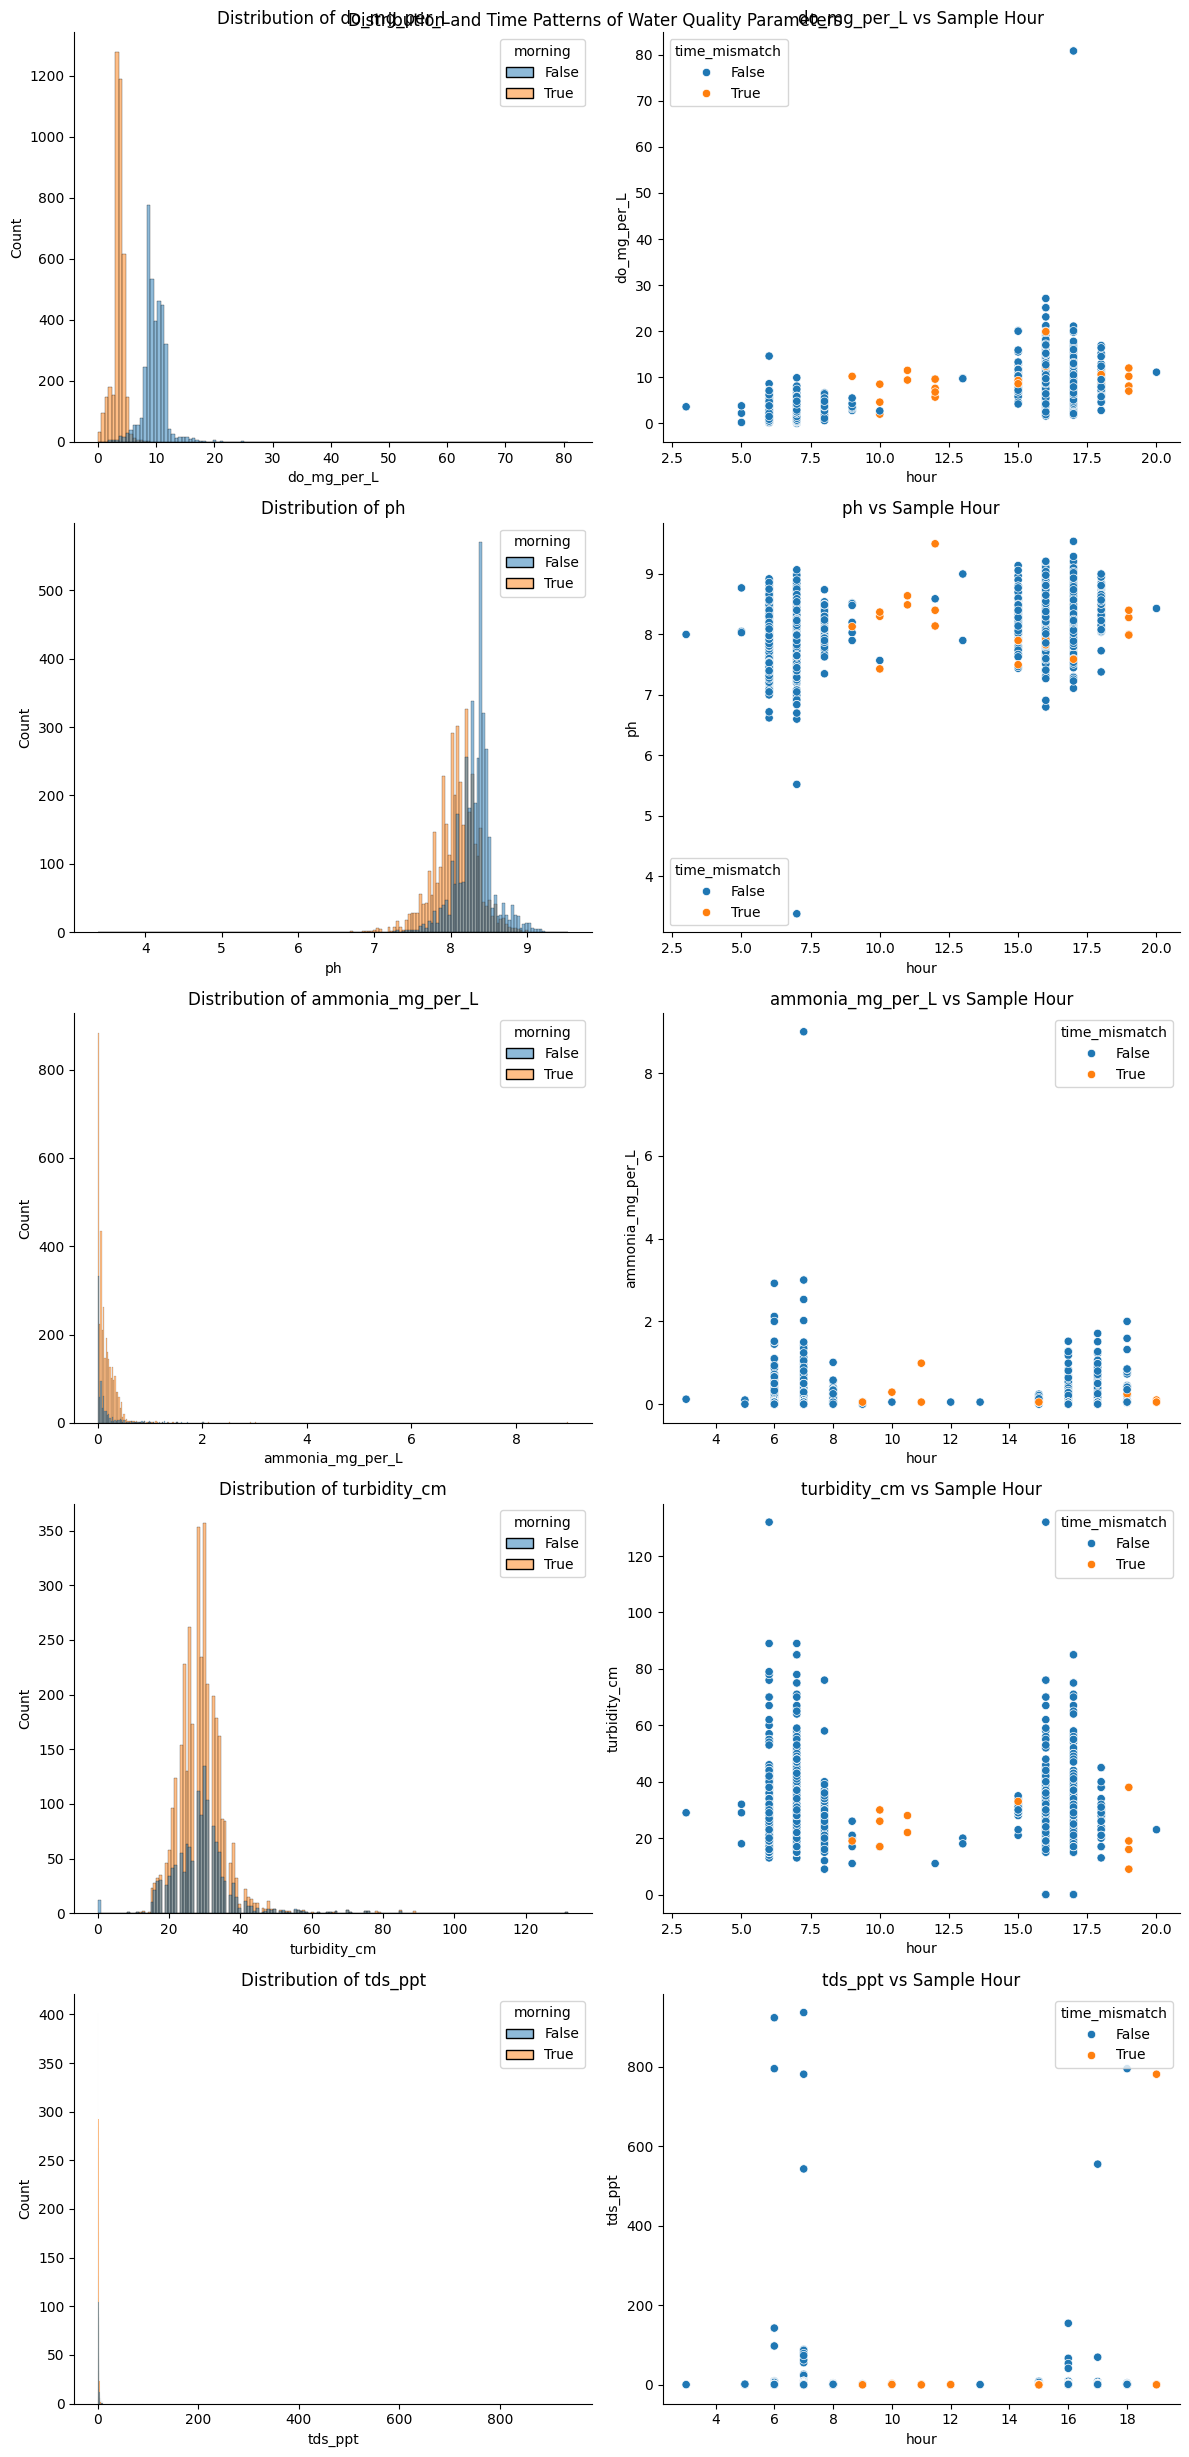

In [513]:
# Create figure with subplots for each outcome variable
outcomes = ['do_mg_per_L', 'ph', 'ammonia_mg_per_L', 'turbidity_cm', 'tds_ppt']

fig, axes = plt.subplots(len(outcomes), 2, figsize=(12, 5*len(outcomes)))
fig.suptitle('Distribution and Time Patterns of Water Quality Parameters')

for i, outcome in enumerate(outcomes):
    # Histogram
    sns.histplot(data=explore_ds, x=outcome, hue='morning', ax=axes[i,0])
    axes[i,0].set_title(f'Distribution of {outcome}')
    axes[i,0].spines['top'].set_visible(False)
    axes[i,0].spines['right'].set_visible(False)
    
    # Scatter plot
    sns.scatterplot(data=explore_ds, x='hour', y=outcome, hue='time_mismatch', ax=axes[i,1])
    axes[i,1].set_title(f'{outcome} vs Sample Hour')
    axes[i,1].spines['top'].set_visible(False)
    axes[i,1].spines['right'].set_visible(False)

plt.tight_layout()


- We might consider some of the very high morning values errors?
- That cluster of time mismatch values above 17.5 are pretty suspicious. Not sure what to think.

#### Check for duplicates

In [519]:
explore_ds[explore_ds.duplicated(['pond_id', 'date', 'sample_time'], keep=False)] # No duplicates

,serial_num,date,sample_time,pond_id,group,pond_status,equipment,do_mg_per_L,ph,turbidity_cm,tds_ppt,ammonia_mg_per_L,follow_up,month_year,sample_dt,hour,time_mismatch,morning,winkler


No duplicates. Check with Jennifer.

Ask Jennifer if there are outliers here we should look more closely at.

In [520]:
# Only use observations from treatment status and not follow up
in_sample = (explore_ds['pond_status'] == 'Treatment') & (~explore_ds['follow_up'])
print(in_sample.sum())
sample_ds = explore_ds[in_sample]

5964


In [522]:
sample_ds = sample_ds.drop(columns=['time_mismatch', 'month_year'])
sample_ds.to_csv("../data/clean/measurements_jun_21_dec_24.csv", index=False)